# Importing libraries

In [80]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import string as s
import re
import nltk
from datetime import datetime
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import Sequential
from keras import layers as l
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import classification_report

In [81]:
startTime = datetime.now()

# Importing data

Importing data source. <br>
Source: https://github.com/t-davidson/hate-speech-and-offensive-language <br>
Classes: 0 - hate speech 1 - offensive language 2 - neither

In [82]:
df = pd.read_csv("labeled_data.txt", delimiter=",")
df = df.iloc[: , 1:]
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [83]:
df.drop(["count", "hate_speech", "offensive_language", "neither"], axis=1, inplace=True)
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# Exploration of data

In [84]:
df.shape

(24783, 2)

In [85]:
df.dtypes

class     int64
tweet    object
dtype: object

In [86]:
df.isnull().sum()

class    0
tweet    0
dtype: int64

In [87]:
df.shape[:1]

(24783,)

In [88]:
df_count = df.groupby("class").count()
df_count["proportion"] = ((df_count["tweet"] / df.shape[:1]) * 100).map('{:,.2f}%'.format)
df_count[["tweet", "proportion"]]

,tweet,proportion
class,,
0,1430,5.77%
1,19190,77.43%
2,4163,16.80%


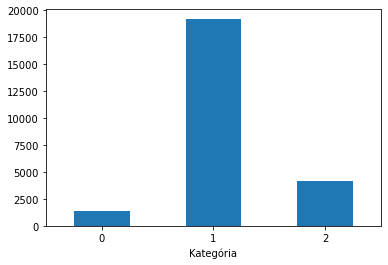

In [89]:
df_count["tweet"].plot.bar()
plt.xlabel("Kategória")
plt.xticks(rotation=0, horizontalalignment="center")
plt.show()

# NLP tasks

Preparatory steps

In [90]:
tokenizer = nltk.tokenize.TweetTokenizer()

stop_words = set(nltk.corpus.stopwords.words("english"))
# add twitter words
stop_words.add("rt")
stop_words.add("dm")

stemmer = nltk.stem.SnowballStemmer("english")

Define preprocessing function. Tokenizes tweet given as a string input and keeps only tokens starting with character or hashtag and tokens that are links. Then stems the token.

In [91]:
def preprocess(text):
    text = str(text).lower()
    tokens = []
    for token in text.split():
        token = stemmer.stem(token)
        if (token not in stop_words) and (re.findall(r'^[a-z#]', token)) and not (re.findall(r'^http', token)):
            token = re.sub('[^a-z0-9#]+', '', token)  
            tokens.append(token)
    return tokens

Apply preprocessing function. Get longest tweets token length. Drops any tweets that only contained irrelevant tokens.

In [92]:
tokens = [preprocess(t) for t in df["tweet"]]
max_len = len(max(tokens, key=len))
df["tokenized"] = [" ".join(t) for t in tokens]
df.dropna(subset=['tokenized'], inplace=True)
df

,class,tweet,tokenized
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman complain clean house man alway take tras...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat coldtyga dwn bad cuffin dat hoe place
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cry confus shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya
...,...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,muthafin lie right tl trash now mine bibl scri...
24779,2,"you've gone and broke the wrong heart baby, an...",youv gone broke wrong heart baby drove redneck...
24780,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like aint fuck...
24781,1,youu got wild bitches tellin you lies,youu got wild bitch tellin lie


Turn texts to sequences of integers.

In [125]:
tokenizer = Tokenizer()
tweets = list(df["tokenized"])
tokenizer.fit_on_texts(tweets)
tweets = tokenizer.texts_to_sequences(tweets)
tweets = pad_sequences(tweets, maxlen=(max_len))
tweets[:1]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0, 268, 617, 556, 976,  32,  96,  59,  13,
        325]], dtype=int32)

Import GloVe vectors from txt file into embeddings_index dictionary

In [94]:
#https://keras.io/examples/nlp/pretrained_word_embeddings/
embeddings_index = {}
with open('glove.6B/glove.6B.50d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

Create embedding matrix 

In [95]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))
hits = 0
misses = 0

for t, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(t)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 11599 words (7946 misses)


Pad sequences to same length, split data into train and test subsets.
Training data = 90%
Validation data = 10%

In [96]:
X_train, X_validate, y_train, y_validate = train_test_split(
    tweets, df["class"], train_size=0.9, random_state=42, stratify=df["class"])
X_train.shape

(22304, 27)

Build CNN model with 3 convolutional layers

Train model

In [150]:
model = Sequential()
model.add(l.Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(l.Conv1D(32, 3, padding='same', activation='relu', 
                   kernel_regularizer=l2(0.01),
                   kernel_initializer='random_normal'))
model.add(l.MaxPooling1D())
model.add(l.Dropout(0.1))
model.add(l.Conv1D(32, 3, padding='same', activation='relu',
                   kernel_regularizer=l2(0.01),
                   kernel_initializer='random_normal'))
model.add(l.MaxPooling1D())
model.add(l.Dropout(0.1)) 
model.add(l.Flatten())
model.add(l.Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
model.add(l.Dropout(0.5)) 
model.add(l.Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 27, 50)            977300    
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 27, 32)            4832      
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 13, 32)            0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 13, 32)            0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 13, 32)            3104      
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 6, 32)             0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 6, 32)           

In [151]:
early_stopping = EarlyStopping(monitor="val_loss",
                               min_delta=0,
                               patience=5,
                               verbose=1)

In [ ]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=128, 
                    epochs=300, 
                    validation_data=(X_validate, y_validate), 
                    callbacks=[early_stopping])

Train on 22304 samples, validate on 2479 samples
Epoch 1/300
22304/22304 [==============================] - 15s 678us/step - loss: 1.9744 - accuracy: 0.7691 - val_loss: 0.6377 - val_accuracy: 0.8165
Epoch 2/300
22304/22304 [==============================] - 14s 639us/step - loss: 0.5806 - accuracy: 0.8191 - val_loss: 0.5264 - val_accuracy: 0.8314
Epoch 3/300
22304/22304 [==============================] - 14s 635us/step - loss: 0.5372 - accuracy: 0.8268 - val_loss: 0.5091 - val_accuracy: 0.8403
Epoch 4/300
22304/22304 [==============================] - 14s 624us/step - loss: 0.5231 - accuracy: 0.8346 - val_loss: 0.4996 - val_accuracy: 0.8399
Epoch 5/300
22304/22304 [==============================] - 14s 622us/step - loss: 0.5100 - accuracy: 0.8409 - val_loss: 0.4913 - val_accuracy: 0.8411
Epoch 6/300
22304/22304 [==============================] - 14s 644us/step - loss: 0.5021 - accuracy: 0.8483 - val_loss: 0.4852 - val_accuracy: 0.8459
Epoch 7/300
22304/22304 [==========================

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Pontosság')
plt.xlabel('Iteráció')
plt.legend(['tanító', 'teszt'], loc='upper left')
plt.savefig('accuracy2.png')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('veszteség')
plt.xlabel('Iteráció')
plt.legend(['tanító', 'teszt'], loc='upper left')
plt.ylim([0.4, 0.7])
plt.savefig('loss2.png')
plt.show()

In [102]:
print('Script run took %s seconds' % (datetime.now() - startTime))

Script run took 0:17:58.567181 seconds
